# Cell Segmemtation (10x HD)

Space Ranger v4.0 introduced nucleus and cell segmentation for Visium HD Spatial Gene Expression and Visium HD 3' Spatial Gene Expression.

However, there are also many interesting cell segmentation implementations in the community, such as stardist and cellpose, among which bin2cell integrates stardist for cell segmentation. Here, we do not want to install stardist based on tensorflow, so we rewrote the cell segmentation part of bin2cell and switched to cellpose based on Python. We hope this will be helpful to you.

Cite: Polański, K., Bartolomé-Casado, R., Sarropoulos, I., Xu, C., England, N., Jahnsen, F. L., ... & Yayon, N. (2024). Bin2cell reconstructs cells from high resolution Visium HD data. Bioinformatics, 40(9), btae546.

Cite: Stringer, C., Wang, T., Michaelos, M., & Pachitariu, M. (2021). Cellpose: a generalist algorithm for cellular segmentation. Nature methods, 18(1), 100-106.

In [1]:
import omicverse as ov
import scanpy as sc
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA H100 80GB HBM3
    • Total memory: 79.1 GB
    • Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.8rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Load Dataset

VisiumHD has the potential to be the most revolutionary technology in the field since droplet based single cell methods. Seeing how it's a fresh development, ways to maximise the utility of the data need to be proposed. Its 2um resolution is subcellular, and should in principle be useable for recreating cells more accurately than just going for the next resolution up (8um) and treating those as cells.

Bin2cell attempts to handle this problem. It starts by correcting for a novel technical effect in the data in variable bin dimensions, and then proposes a bin to cell assignment based on image segmentation. The result is an object with putative cells in it, ready for downstream analysis. The segmentation can be performed on both the morphology (H&E/IF) image and a visualisation of gene expression data, with certain caveats for both that will be discussed within the notebook.

We download the count data and HE image from https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-human-crc.

In [29]:
from pathlib import Path

def print_tree(path: Path, prefix: str = ""):
    print(prefix + path.name + "/")
    for child in path.iterdir():
        if child.is_dir():
            print_tree(child, prefix + "    ")
        else:
            print(prefix + "    " + child.name)

print_tree(Path("binned_outputs/square_002um/"))


square_002um/
    spatial/
        aligned_fiducials.jpg
        detected_tissue_image.jpg
        tissue_positions.parquet
        aligned_tissue_image.jpg
        tissue_lowres_image.png
        cytassist_image.tiff
        tissue_hires_image.png
        scalefactors_json.json
    raw_feature_bc_matrix.h5
    filtered_feature_bc_matrix/
        barcodes.tsv.gz
        features.tsv.gz
        matrix.mtx.gz
    raw_probe_bc_matrix.h5
    filtered_feature_bc_matrix.h5
    raw_feature_bc_matrix/
        barcodes.tsv.gz
        features.tsv.gz
        matrix.mtx.gz


In [9]:
path = "binned_outputs/square_002um/"
source_image_path = "Visium_HD_Human_Colon_Cancer_tissue_image.btf"
#os.chdir('./')

#create directory for stardist input/output files
import os
os.makedirs("stardist", exist_ok=True)

Loading the count matrix currently requires a bespoke loader function as 10X have moved the spot coordinates into a Parquet file, and started storing their tissue images into a separate spatial folder (with symlinks in the binned folders, which may break on transfer).

In [10]:
adata = ov.space.read_visium_10x(path, source_image_path = source_image_path)
adata.var_names_make_unique()
adata

reading binned_outputs/square_002um/filtered_feature_bc_matrix.h5
 (0:00:14)


AnnData object with n_obs × n_vars = 8731400 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Let's slightly filter the object - require the genes to show up in three spots, and require the spots to have any information at all (the data is extremely sparse at this stage).

In [11]:
ov.pp.filter_genes(adata, min_cells=3)
ov.pp.filter_cells(adata, min_counts=1)
adata

🔍 Filtering genes...
   Parameters: min_cells≥3
filtered out 27 genes that are detected in less than 3 cells
   ✓ Filtered: 27 genes removed
🔍 Filtering cells...
   Parameters: min_counts≥1
filtered out 475557 cells that have less than 1 counts
   ✓ Filtered: 475,557 cells removed


AnnData object with n_obs × n_vars = 8255843 × 18058
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

## HE Cell Segmenation with Cellpose

Over the course of the demo, bin2cell will perform a segmentation of both the H&E image and a gene expression representation of the data. When performing segmentation, the resolution of the input images is controlled via the mpp parameter. This stands for microns per pixel and translates to how many micrometers are captured in each pixel of the input. For example, if using the array coordinates (present as .obs["array_row"] and .obs["array_col"]) as an image, each of the pixels would have 2 micrometers in it, so the mpp of that particular representation is 2.

In local testing of the mouse brain, using an mpp of 0.5 has worked well with both GEX and H&E segmentation. The StarDist models were trained on images with an mpp closer to 0.3.

In [24]:
ov.space.visium_10x_hd_cellpose_he(
    adata,
    mpp=0.3,
    he_save_path="stardist/he_colon1.tiff",
    prob_thresh=0,
    flow_threshold=0.4,
    gpu=True,
    buffer=150,
    backend='tifffile',
)

he_save_path stardist/he_colon1.tiff already exists, skipping destripe and scaled_he_image


Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.10.17 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




model_type argument is not used in v4.0.1+. Ignoring this argument...
bin2cell.stardist: 100%|██████████| 156/156 [05:50<00:00,  2.25s/tile]


However, StarDist's H&E segmentation merely identifies nuclei, while there's more to a cell than just the nucleus. `ov.space.visium_10x_hd_cellpose_expand()` finds bins up to max_bin_distance (by default 2) bins away from a labelled nucleus, and joins them into the corresponding cell. Alternately, passing algorithm="volume_ratio" has each label get a custom expansion distance derived from its bin count, based on the linear relationship between cell and nuclear volume, controlled by volume_ratio with a default of 4. In the event of a bin being equidistant from multiple nuclei, it's assigned to one based on the similarity of their gene expression profiles, as represented in PCA space.

In [34]:
ov.space.visium_10x_hd_cellpose_expand(
    adata,
    labels_key='labels_he', 
    expanded_labels_key="labels_he_expanded",
    max_bin_distance=4,
)

computing PCA
    with n_comps=50
    finished (0:00:38)


## GEX Cell Segmenation with Cellpose

The H&E segmentation is not guaranteed to be perfect. There may be some regions that have expression data but lack a visible nuclei to seed a cell. Alternately, nuclei may take on unusual shapes and not be detected by the model. Performing segmentation on a representation of total expression per bin may be able to detect some of the missed cells. However, this kind of segmentation only performs well on sparse tissue, and struggles to differentiate individual cells in dense regions. As such, we use it as secondary means of object identification, preferring H&E where able.

The input image is going to be a representation of the total counts per bin, with a Gaussian filter with a sigma of 5 (measured in pixels) applied for a little smoothing.

The segmentation is performed via StarDist's fluorescence model, and identifies cells rather than nuclei, meaning subsequent label expasion is not necessary. Just like with the H&E model, lowering prob_thresh to make the calls less stringent is recommended. Increasing nms_thresh requires more of the putative objects to be overlapping for them to be merged into a single label, which may help a bit in denser regions.

In [10]:
ov.space.visium_10x_hd_cellpose_gex(
    adata,
    obs_key="n_counts_adjusted",
    log1p=False,
    mpp=0.3,
    sigma=5,
    gex_save_path="stardist/gex_colon1.tiff",
    prob_thresh=0.01,
    nms_thresh=0.1,
    gpu=True,
    buffer=150,
)

model_type argument is not used in v4.0.1+. Ignoring this argument...
bin2cell.stardist: 100%|██████████| 169/169 [05:08<00:00,  1.83s/tile]


In [36]:
ov.space.salvage_secondary_labels(
    adata, 
    primary_label="labels_he_expanded", 
    secondary_label="labels_gex", 
    labels_key="labels_joint"
)

Salvaged 841 secondary labels


In [ ]:
adata.write('visium_hd/adata_cellpose.h5ad')

## Bin to Cell

At this point, the counts have been destriped and bins have been assigned to cells based on both H&E and GEX segmentation. Time to group the bins into cells!

In [37]:
cdata = ov.space.bin2cell(
    adata, labels_key="labels_joint", 
    spatial_keys=["spatial", "spatial_cropped_150_buffer"])
cdata

AnnData object with n_obs × n_vars = 84881 × 18058
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

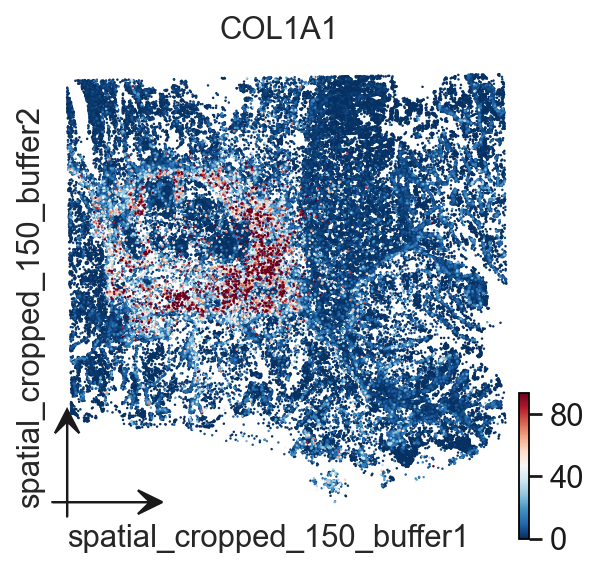

In [38]:
ov.pl.embedding(
    cdata,
    basis='spatial_cropped_150_buffer',
    color=['COL1A1'],
    vmax='p99.2',cmap='RdBu_r',
    size=5,
)

## Visualization

In [7]:
#define a mask to easily pull out this region of the object in the future
mask = ((adata.obs['array_row'] >= 2225) & 
        (adata.obs['array_row'] <= 2275) & 
        (adata.obs['array_col'] >= 1400) & 
        (adata.obs['array_col'] <= 1450))

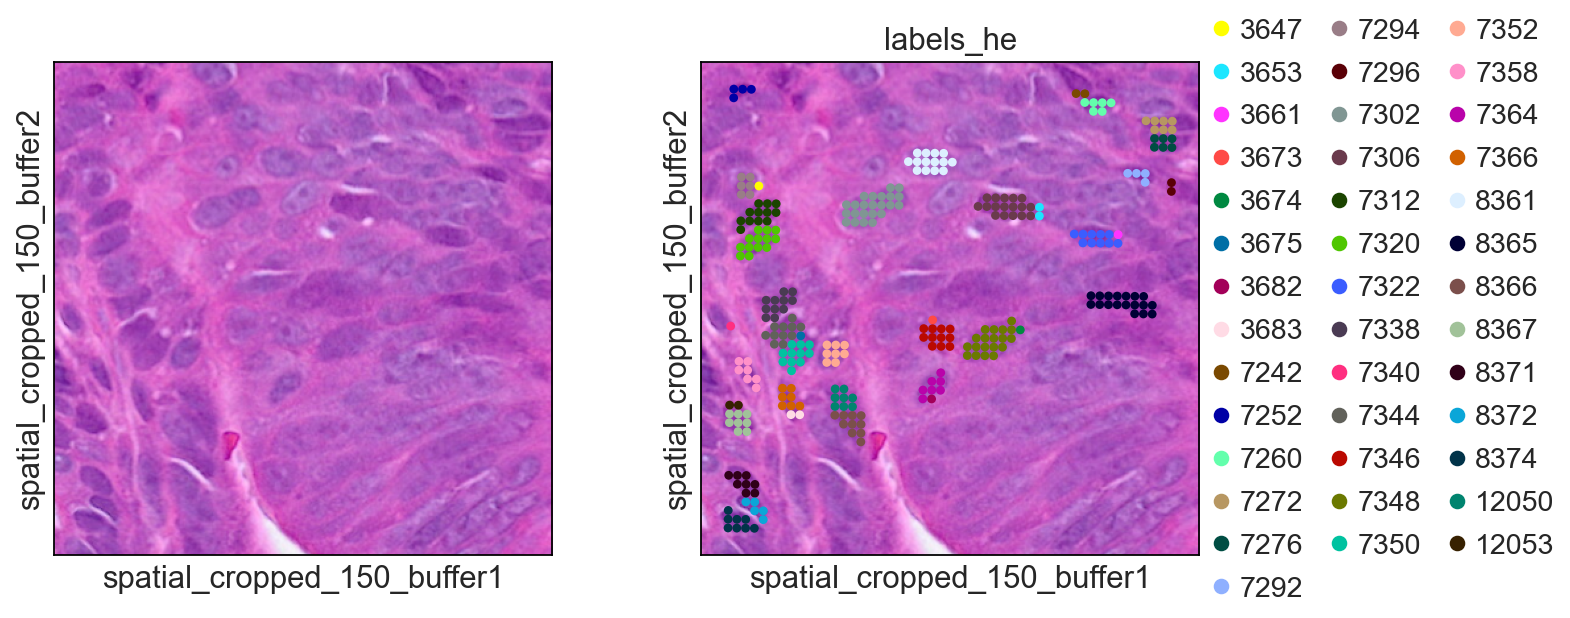

In [8]:

bdata = adata[mask]
#0 means unassigned
bdata = bdata[bdata.obs['labels_he']>0]
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he"], img_key="0.3_mpp_150_buffer", 
              basis="spatial_cropped_150_buffer")

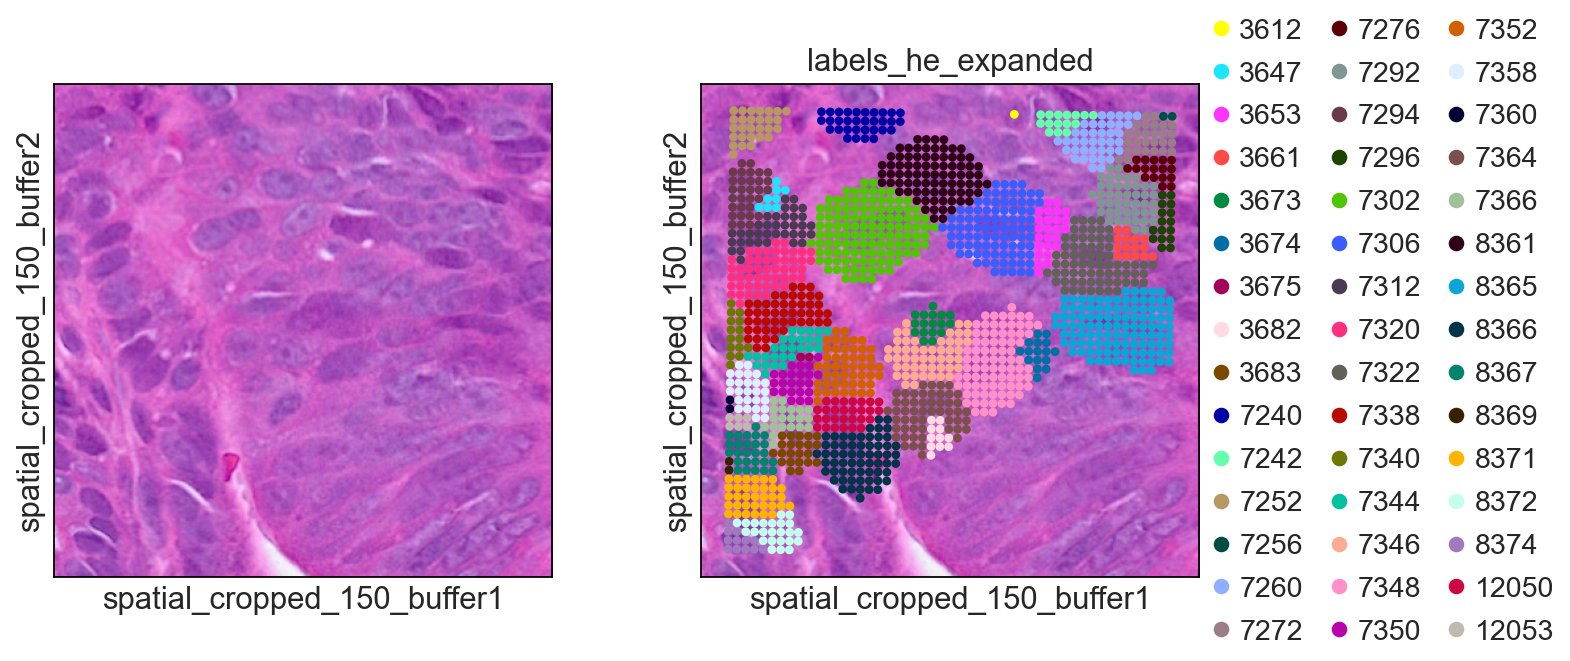

In [15]:
bdata = adata[mask]
#0 means unassigned
bdata = bdata[bdata.obs['labels_he_expanded']>0]
bdata.obs['labels_he_expanded'] = bdata.obs['labels_he_expanded'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he_expanded"], img_key="0.3_mpp_150_buffer", 
              basis="spatial_cropped_150_buffer")

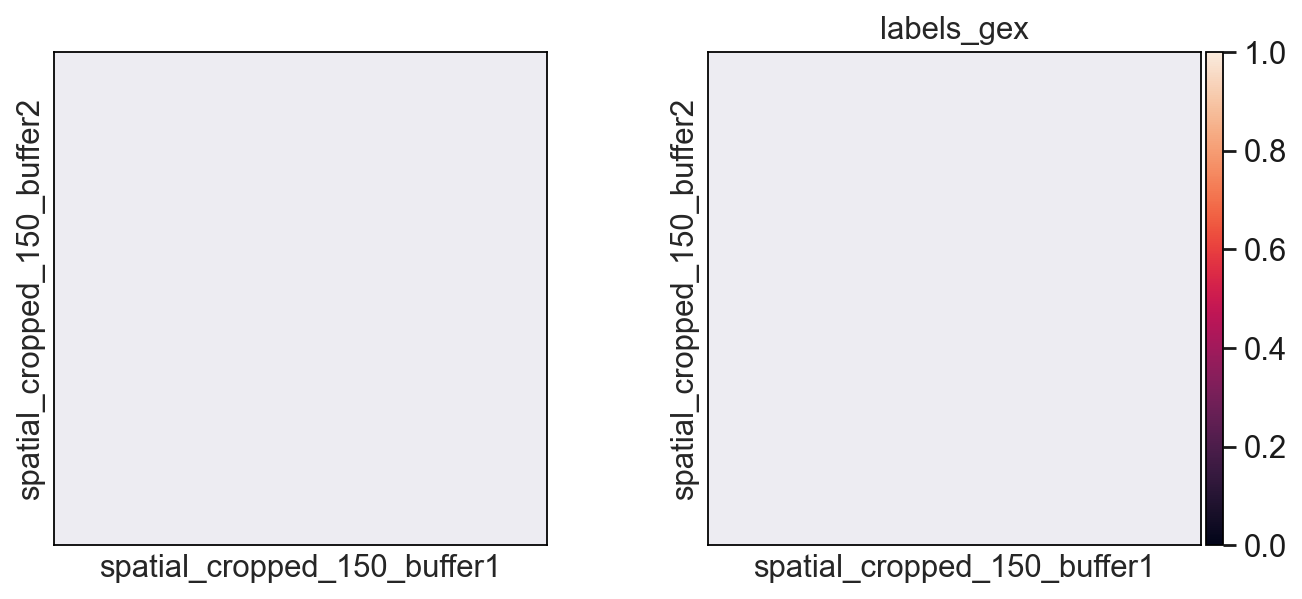

In [16]:
bdata = adata[mask]
#0 means unassigned
bdata = bdata[bdata.obs['labels_gex']>0]
bdata.obs['labels_gex'] = bdata.obs['labels_gex'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_gex"], img_key="0.3_mpp_150_buffer", 
              basis="spatial_cropped_150_buffer")

In [ ]:
bdata = adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_joint']>0]
bdata.obs['labels_joint'] = bdata.obs['labels_joint'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_joint_source", 
                            "labels_joint"], img_key="0.3_mpp_150_buffer", 
              basis="spatial_cropped_150_buffer")